Problem: based on the given data of historical real estate transactions create the decision-making model (DMM) which aims to predict prices of new real estate objects.

Project workflow:
* P1. Perform given data analysis and preprocessing
* P2. Implement K-Nearest Neighbors (KNN), Decision tree (DT), and random forest (RF) algorithms (You cannot use library functions for these algorithms)
* P3. Use implemented algorithms to create DMM for the given problem and evaluate the results.
* P4. Use “scikit-learn” (or other) library functions for the same algorithms and evaluate the results.
* P5. Write conclusions.

Data:
* historicalData.tsv – data to create the DMMs.
* newData.tsv – assume, that you don’t have this data. We use this data only to evaluate (during work defense) how DMM model works with unseen data.


Workflow requirements in detail

P1. Data analysis and preprocessing
* determine data types of features.
* provide data quality report for all features (analyze categorical and continuous features separately). The form of the report is given in slides (Input Analysis).
* provide distribution characteristics (histogram, frequency table, bar plot, box plot, pie chart …) based on the data type for each feature. For numerical features, explore the shape of distribution, perform standardization or normalization. Consider the normality of data.
* comment whether it is possible to include derived features (ratios, flags, mapping, etc.) and append Analytics Base Table (ABT) if needed. 
* perform data preprocessing actions if You think it is necessary

P2. Implementation of KNN, DT, and RF
* Requirements for algorithms (parameters to change)
    * KNN – k value
    * DT – minSamplesLeaf; maxDepth.
    * RF – nEstimators;
* Implementation can be based on lectures or online materials, but references to the original source (if used) are necessary. Student must be able to comment any line (even if it is used from examples or other materials).

P3 and P4.
* Creating DMM means to select optimal hyper-parameters and perform output analysis.
* Evaluate results using MAE, MAPE metrics.
* Scikit-learn library models:
    * https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    * https://scikit-learn.org/stable/modules/tree.html
    * https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

P5. Work conclusions
* compare the results of DMMs that use Your implementation and “scikit-learn” library.

Original data set available at: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

----

P1. Data analysis and preprocessing
* determine data types of features.
* provide data quality report for all features (analyze categorical and continuous features separately). The form of the report is given in slides (Input Analysis).
* provide distribution characteristics (histogram, frequency table, bar plot, box plot, pie chart …) based on the data type for each feature. For numerical features, explore the shape of distribution, perform standardization or normalization. Consider the normality of data.
* comment whether it is possible to include derived features (ratios, flags, mapping, etc.) and append Analytics Base Table (ABT) if needed. 
* perform data preprocessing actions if You think it is necessary

----

In [1]:
import csv
import pandas
import matplotlib.pyplot as plt
import random
import numpy

In [4]:
# Read data
fd = open("../data/historicalData.tsv")
rows = list(csv.reader(fd, delimiter="\t"))
fd.close()
df = pandas.DataFrame(rows[1:], columns = rows[0])
df = df.set_index("Id")

numeric_cols = ["LotFrontage", "LotArea", "YearBuilt", "YearRemodAdd", "SalePrice"]
categorical_cols = ["Street", "Neighborhood", "CentralAir", "PavedDrive", "SaleCondition"]
df[numeric_cols] = df[numeric_cols].apply(pandas.to_numeric, errors='coerce')

display(df)

,LotFrontage,LotArea,Street,Neighborhood,YearBuilt,YearRemodAdd,CentralAir,PavedDrive,SaleCondition,SalePrice
Id,,,,,,,,,,
1,65.0,8450,Pave,CollgCr,2003,2003,Y,Y,Normal,208500
2,80.0,9600,Pave,Veenker,1976,1976,Y,Y,Normal,181500
3,68.0,11250,Pave,CollgCr,2001,2002,Y,Y,Normal,223500
4,60.0,9550,Pave,Crawfor,1915,1970,Y,Y,Abnorml,140000
5,84.0,14260,Pave,NoRidge,2000,2000,Y,Y,Normal,250000
...,...,...,...,...,...,...,...,...,...,...
995,96.0,12456,Pave,NridgHt,2006,2007,Y,Y,Normal,337500
996,51.0,4712,Pave,BrkSide,1946,1950,Y,Y,Abnorml,121600
997,NaN,10659,Pave,NAmes,1961,1961,Y,Y,Normal,136500


We can see that data has 5 numeric columns:
* LotFrontage
* LotArea
* YearBuilt
* YearRemodAdd
* SalePrice

and 5 categorical columns:
* Street
* Neighborhood
* CentralAir
* PavedDrive
* SaleCondition

Lets start with numeric data:
* Plot distributions
* Data quality report

,count,missing,cardinality,min,q1,median,q3,max,mean,std
name,,,,,,,,,,
LotFrontage,999,17.32,103,21.0,60.0,70.0,80.0,313.0,69.96,23.22
LotArea,999,0.00,780,1300.0,7589.0,9452.0,11632.0,215245.0,10695.11,11417.71
YearBuilt,999,0.00,107,1880.0,1954.0,1974.0,2000.0,2010.0,1971.60,30.00
YearRemodAdd,999,0.00,61,1950.0,1967.0,1994.0,2004.0,2010.0,1985.26,20.41
SalePrice,999,0.00,536,34900.0,130000.0,163990.0,215000.0,755000.0,182260.71,80327.92


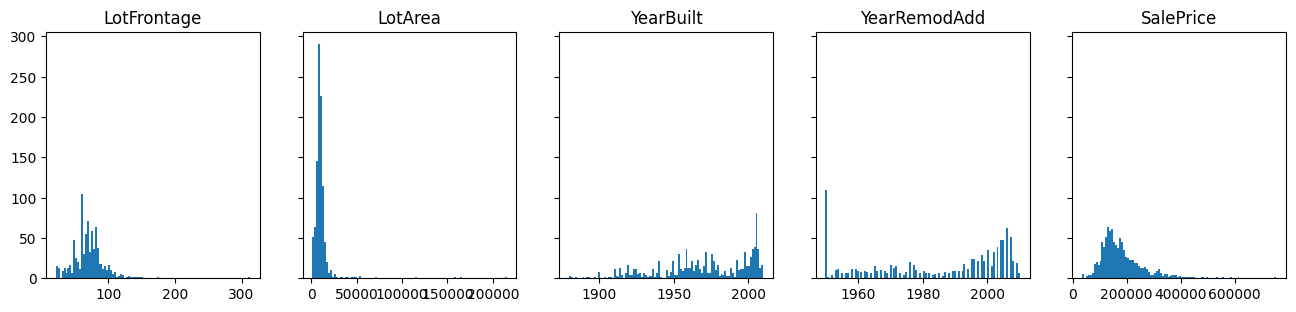

In [5]:
def numeric_report(col):
    count = len(col)
    missing = col.isna().sum()
    cardinality = len(col.unique())
    res = {
        "name": col.name,
        "count": count,
        "missing": round(missing / count * 100, 2),
        "cardinality": cardinality,
        "min": min(col),
        "q1": col.quantile(0.25),
        "median": col.quantile(0.5),
        "q3": col.quantile(0.75),
        "max": max(col),
        "mean": round(col.mean(), 2),
        "std": round(col.std(), 2)
    }
    return(res)

n_repo = pandas.DataFrame([numeric_report(df[col]) for col in numeric_cols])
n_repo = n_repo.set_index("name")
display(n_repo)

fig, axs = plt.subplots(1, len(numeric_cols), sharey=True, figsize=(16, 16 / len(numeric_cols)))
for i in range(len(numeric_cols)):
    name = numeric_cols[i]
    axs[i].hist(df[name], bins = 100)
    axs[i].set_title(name)
qqq = plt.plot()

From the histograms we can clearly see that there are some outliers in the data (e.g. LotArea).\
We will remove these outliers by limiting our data to not be deviated by more than 4 std from the mean.

But before that lets perform categorical data analysis:
* Various plots
* Data quality report


,count,missing,cardinality,mode,mode f.,mode %,2nd mode,2nd mode f.,2nd mode %,values
name,,,,,,,,,,
Street,999,0.0,2,Pave,995,99.60,Grvl,4,0.40,Pave|Grvl
Neighborhood,999,0.0,25,NAmes,152,15.22,CollgCr,100,10.01,CollgCr|Veenker|Crawfor|NoRidge|Mitchel|Somers...
CentralAir,999,0.0,2,Y,931,93.19,N,68,6.81,Y|N
PavedDrive,999,0.0,3,Y,917,91.79,N,61,6.11,Y|N|P
SaleCondition,999,0.0,6,Normal,812,81.28,Partial,91,9.11,Normal|Abnorml|Partial|AdjLand|Alloca|Family


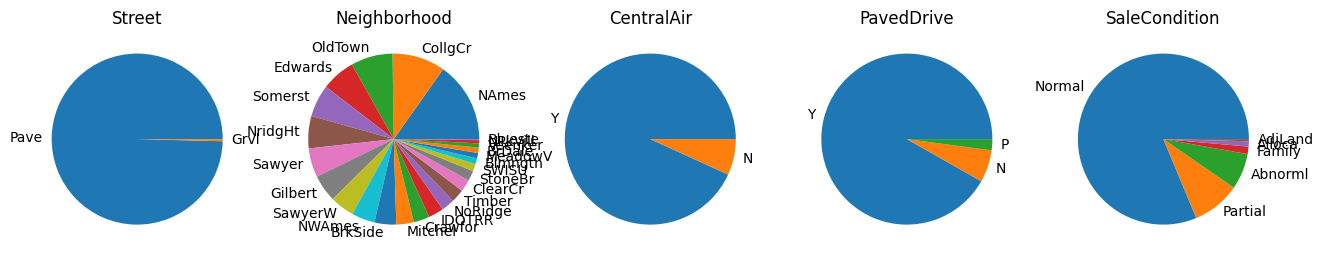

In [15]:
def categorical_report(col):
    count = len(col)
    missing = col.isna().sum()
    cardinality = len(col.unique())

    value_counts = col.value_counts()
    my_mode = value_counts.index.tolist()[0]
    my_mode_c = value_counts[0]
    my_mode_f = round(my_mode_c / count * 100, 2)
    my_mode2 = value_counts.index.tolist()[1]
    my_mode_c2 = value_counts[1]
    my_mode_f2 = round(my_mode_c2 / count * 100, 2)

    values = "|".join(col.unique().tolist())
    
    res = {
        "name": col.name,
        "count": count,
        "missing": round(missing / count * 100, 2),
        "cardinality": cardinality,
        "mode": my_mode,
        "mode f.": my_mode_c,
        "mode %": my_mode_f,
        "2nd mode": my_mode2,
        "2nd mode f.": my_mode_c2,
        "2nd mode %": my_mode_f2,
        "values": values
    }
    return(res)

c_repo = pandas.DataFrame([categorical_report(df[col]) for col in categorical_cols])
c_repo = c_repo.set_index("name")
display(c_repo)

fig, axs = plt.subplots(1, len(categorical_cols), sharey=True, figsize=(16, 16 / len(categorical_cols)))
for i in range(len(categorical_cols)):
    name = categorical_cols[i]
    tmp = df[name].value_counts()
    axs[i].pie(tmp, labels = tmp.index)
    axs[i].set_title(name)
qqq = plt.plot()

From pie plots and data quality report we can see that:
* Column "Street" is almost irrelevant (99% of streets are paved)
* Column "Neighborhood" could be useful, but it would introduce 25 new futures to our model. With only 999 (before discarding outliers) rows, i don't it's feasible to use this column. But lets check its corelation with price just for fun.
* Column "CentralAir" seams great.
* Column "PAvedDrive" seems also great, but it includes value P, i think it should mean "Paved", but we will discard it.
* Column "Sales Condition" also is great, but it has cardinality of 6. We can covert this column to "IsNormal".

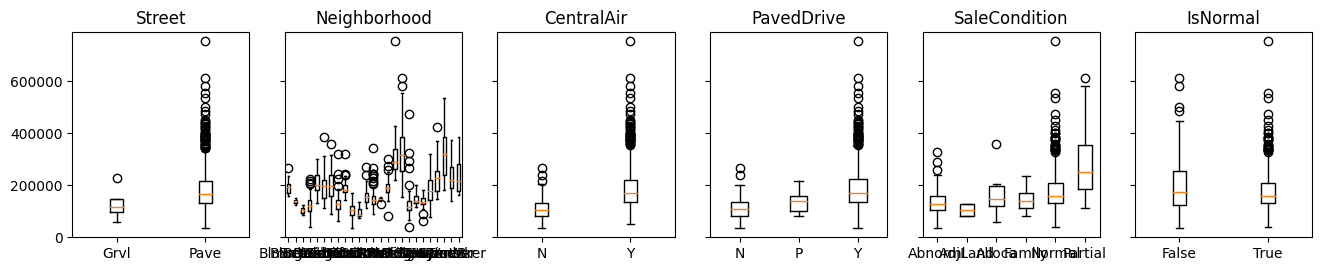

In [16]:
fig, axs = plt.subplots(1, len(categorical_cols) + 1, sharey=True, figsize=(16, 16 / (len(categorical_cols) + 1)))
for i in range(len(categorical_cols)):
    name = categorical_cols[i]
    tmp = df[[name, "SalePrice"]].groupby(name)["SalePrice"].apply(list)
    axs[i].boxplot(tmp, labels = tmp.index)
    axs[i].set_title(name)
tmp = df[[name, "SalePrice"]].copy()
tmp["IsNormal"] = tmp["SaleCondition"] == "Normal"
tmp = tmp[["IsNormal", "SalePrice"]].groupby("IsNormal")["SalePrice"].apply(list)
axs[len(categorical_cols)].boxplot(tmp, labels = tmp.index)
axs[len(categorical_cols)].set_title("IsNormal")
qqq = plt.plot()

After looking at box plots, we can notice that only columns "CentralAir" and "PavedDrive" have noticeable corelation with price. The assumption about "IsNormal was wrong.

Data cleaning:

In [17]:
def filter_numeric(v, std_n):
    n = len(v)
    bv = [True] * n
    def reduce(v, n):
        tmp = v[bv]
        std = tmp.std()
        mean = tmp.mean()
        minstd = mean - std * std_n
        maxstd = mean + std * std_n
        res = (minstd <= v) & (v <= maxstd)
        if(sum(res) == n): return(res)
        return(reduce(v, sum(res)))
    return(reduce(v, n))

my_filter = [True] * df.shape[0] 
for i in numeric_cols:
    my_filter = my_filter & filter_numeric(df[i], 2)

my_filter = my_filter & (df["PavedDrive"] != "P")

new_df = df[my_filter].copy()
old_df = df.copy()

print(sum(my_filter))

695


Lets rerun our analysis with cleaned data.\
After rerunning:
* Histograms shows more "Normal" distribution
* Box plot, conclusions didn't change but we can see, the results a bit more clearly
* std of 2 was selected, because it still gives us 695 rows (999-695=304)
    * std of 3: 999 - 779 = 220
    * std of 4: 999 - 797 = 202

After cleaning our data, lets normalize it, and drop unnecessary columns.

It's also possible to add additional feature, frontage to area ratio

In [18]:
# df = new_df

new_df["area_frontage"] = new_df["LotArea"] / new_df["LotFrontage"]
numeric_cols = ["LotFrontage", "LotArea", "YearBuilt", "YearRemodAdd", "SalePrice", "area_frontage"]

In [19]:
relevant_cat_cols = ["CentralAir", "PavedDrive"]


def get_norm_args(df):
    res = pandas.DataFrame([{"name": df[col].name, "std": df[col].std(), "mean": df[col].mean()} for col in df.columns])
    res = res.set_index("name")
    return(res)
my_norm_args = get_norm_args(new_df[numeric_cols])
my_norm_df = new_df[numeric_cols + relevant_cat_cols].copy()

def norm_df(df, args):
    df = df.copy()
    for i in args.index:
        df[i] = (df[i] - args.loc[i, "mean"]) / args.loc[i, "std"]
    for i in df.columns[df.dtypes == "object"]:
        df[i] = [1 if j == "Y" else -1 for j in df[i]]
    return(df)

def de_norm_df(df, args):
    df = df.copy()
    for i in args.index:
        df[i] = (df[i] * args.loc[i, "std"]) + args.loc[i, "mean"]
    return(df)

my_norm_df = norm_df(my_norm_df, my_norm_args)

Lets rerun our analysis with normalized data. The data quality report should be easier to understand now

Also lets produce scatter matrix\
From the scatter matrix we can see clear corelation on majority of columns with SalePrice, but there is no corelation with our derived column "area_frontage"

,count,missing,cardinality,min,q1,median,q3,max,mean,std
name,,,,,,,,,,
LotFrontage,695,0.0,81,-2.523652,-0.510210,0.065059,0.697855,2.768824,0.0,1.0
LotArea,695,0.0,539,-2.444808,-0.594169,-0.056689,0.478791,5.211329,-0.0,1.0
YearBuilt,695,0.0,93,-2.129931,-0.658736,0.041833,1.022629,1.267828,-0.0,1.0
YearRemodAdd,695,0.0,61,-1.668638,-0.953684,0.476225,0.905197,1.191179,0.0,1.0
SalePrice,695,0.0,417,-2.231401,-0.699169,-0.216032,0.571602,2.766308,-0.0,1.0
area_frontage,695,0.0,474,-1.818479,-0.441593,-0.183714,0.188724,10.041426,-0.0,1.0


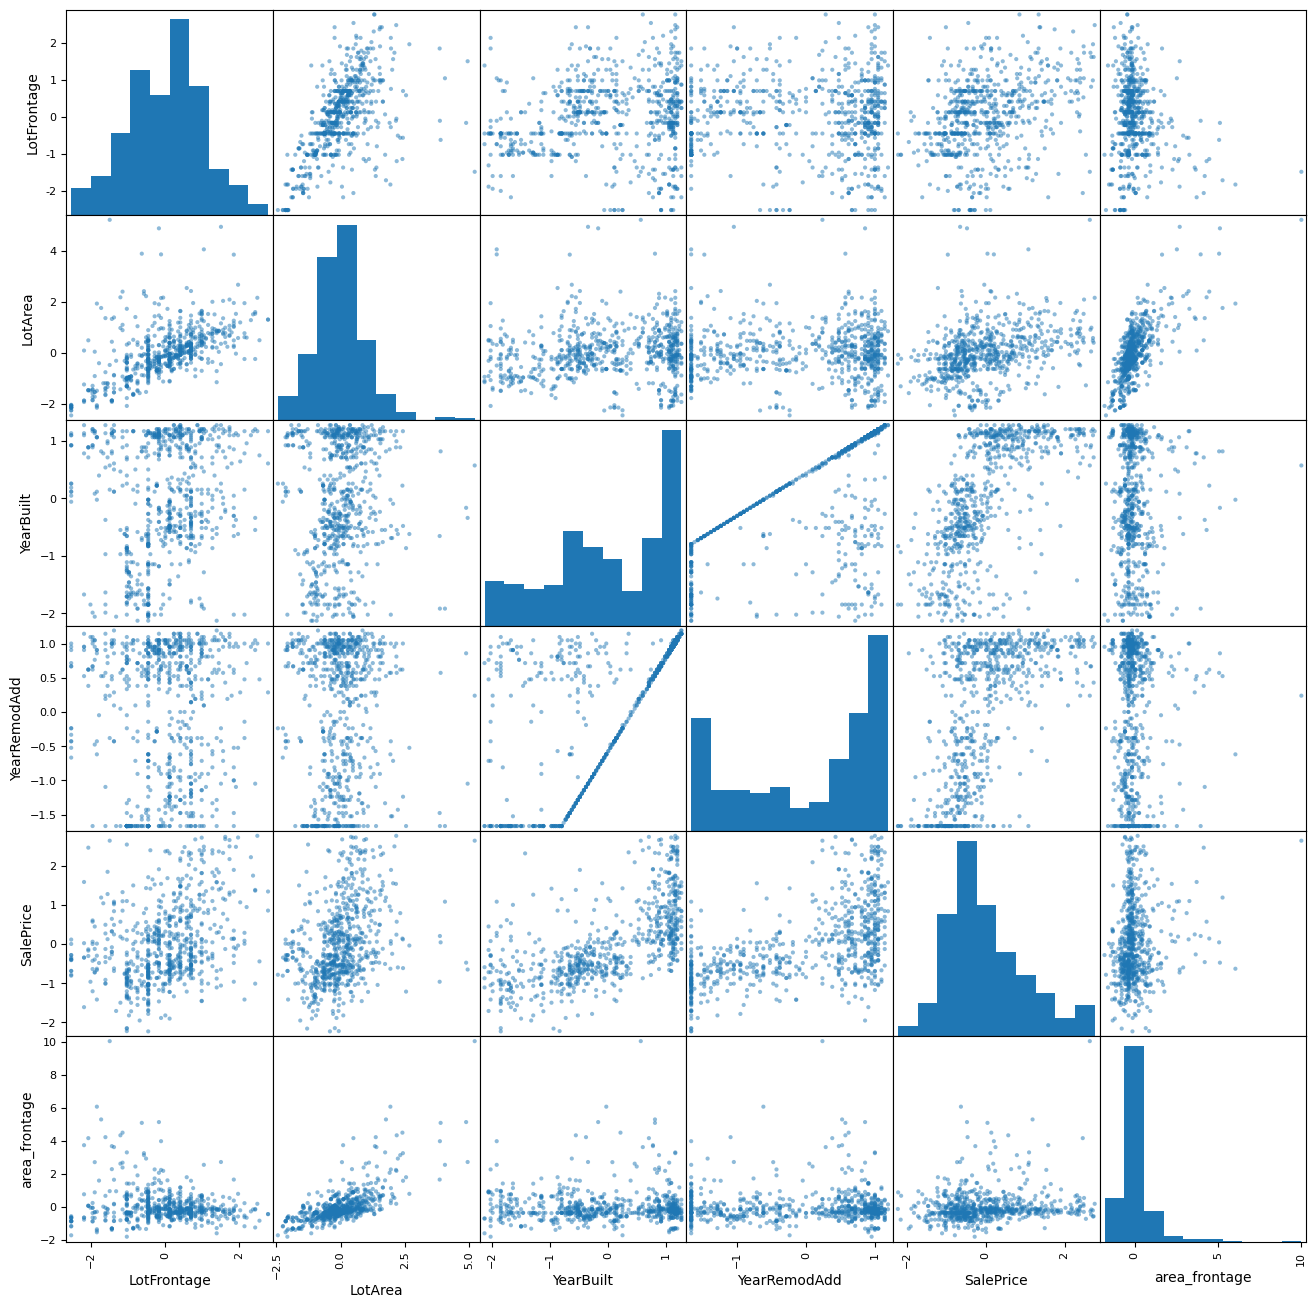

In [20]:
n_repo = pandas.DataFrame([numeric_report(my_norm_df[col]) for col in numeric_cols])
n_repo = n_repo.set_index("name")
display(n_repo)

qqq = pandas.plotting.scatter_matrix(my_norm_df[numeric_cols], figsize=[16, 16])

----

P2. Implementation of KNN, DT, and RF
* Requirements for algorithms (parameters to change)
    * KNN – k value
    * DT – minSamplesLeaf; maxDepth.
    * RF – nEstimators;
* Implementation can be based on lectures or online materials, but references to the original source (if used) are necessary. Student must be able to comment any line (even if it is used from examples or other materials).

----

Lets mix our data first\
To remove any patterns from data entry (Have clean test, train split)

In [21]:
my_norm_df = my_norm_df.loc[random.sample(my_norm_df.index.to_list(), int(my_norm_df.shape[0]))]

In [27]:
class KNN:
    def __init__(self, features, label):
        self.features = features
        self.label = label
        self.len = features.shape[0]
    def __get_distance(self, features):
        res = (((self.features - features) ** 2).sum(axis = 1) ** 0.5).sort_values()
        return(res)
    def __predict_single(self, features, k):
        k = min([k, self.len])
        ids = self.__get_distance(features)[0:k].index
        res = self.label.loc[ids].mean()
        return(res)
    def predict(self, features, k):
        if not isinstance(features, pandas.DataFrame): return(self.__predict_single(features, k))
        features[self.label.name] = features.apply(lambda row: self.__predict_single(row, k), axis=1)
        res = features[[self.label.name]]
        return res

knn_model = KNN(my_norm_df.drop("SalePrice", axis=1), my_norm_df["SalePrice"])
res = knn_model.predict(my_norm_df.drop("SalePrice", axis=1), k = 10)
tmppp = de_norm_df(res, my_norm_args.loc[["SalePrice"]])
tmppp["real"] = de_norm_df(my_norm_df, my_norm_args.loc[["SalePrice"]])["SalePrice"]
tmppp["diff"] = abs(tmppp["real"] - tmppp["SalePrice"])
tmppp["diff+"] = tmppp["diff"] / tmppp["real"]
tmppp = tmppp.sort_values("diff")
display(tmppp)
print(tmppp["diff"].mean())
print(tmppp["diff+"].mean())
#tmppp["diff"] 


#tmppp["real"] = my_norm_df["SalePrice"]
#display(tmppp)
df.loc[["82", "776", "484"]]


,SalePrice,real,diff,diff+
Id,,,,
705,213047.4,213000.0,47.4,0.000223
81,193550.0,193500.0,50.0,0.000258
95,204625.0,204750.0,125.0,0.000611
934,189839.0,190000.0,161.0,0.000847
52,114280.0,114500.0,220.0,0.001921
...,...,...,...,...
115,149020.0,259500.0,110480.0,0.425742
201,253428.4,140000.0,113428.4,0.810203
46,203435.0,319900.0,116465.0,0.364067


25703.566618705037
0.15757788478156856


,LotFrontage,LotArea,Street,Neighborhood,YearBuilt,YearRemodAdd,CentralAir,PavedDrive,SaleCondition,SalePrice
Id,,,,,,,,,,
82,32.0,4500,Pave,Mitchel,1998,1998,Y,Y,Normal,153500
776,32.0,4500,Pave,Mitchel,1998,1998,Y,Y,Normal,162000
484,32.0,4500,Pave,Mitchel,1998,1998,Y,Y,Normal,164000


If we run KNN model with training data we don't get 100% accuracy.
Why? Some data are identical but have different prices

----

[Decision Tree Regression Clearly Explained!](https://www.youtube.com/watch?v=UhY5vPfQIrA) by [Normalized Nerd](https://www.youtube.com/c/NormalizedNerd) 2021-02-04 5:40

https://www.analyticsvidhya.com/blog/2020/06/4-ways-split-decision-tree/#:~:text=Decision%20Tree%20Splitting%20Method%20%231,is%20split%20into%20child%20nodes.

----

In [23]:

def get_variance(series):
    if(series.size <= 1): return(0)
    var = series.var()
    return(var)

def get_split_val(feature, label):
    feature = feature.sort_values()
    total = get_variance(label)
    max_var_red = 0
    max_i = 0
    for i in range(1, len(feature)):
        left = get_variance(label.loc[feature[0:i].index])
        right = get_variance(label.loc[feature[i:].index])
        var_red = total - ((i / label.size) * left) - (((label.size - i) / label.size) * right)
        if(max_var_red < var_red):
            max_var_red = var_red
            max_i = i
    split_val = feature[max_i] if max_var_red != 0 else None
    return({"name": feature.name, "val": split_val, "var_red": max_var_red})

def get_split_label(features, label):
    res = pandas.DataFrame(features.apply(lambda col: get_split_val(col, label)).to_list())
    res = res[res.var_red == res.var_red.max()]
    return({"name": res.iloc[0]["name"], "val": res.iloc[0]["val"]})

class Node:
    def __init__(self, features, label, max_depth = 10, cur_depth = 1, min_samples_leaf = 5):
        self.features = features
        self.label = label
        self.left = None
        self.right = None
        self.name = None
        self.val = None
        self.max_depth = max_depth
        self.cur_depth = cur_depth
        self.min_samples_leaf = min_samples_leaf
    def construct(self):
        if self.cur_depth <= self.max_depth & self.features.shape[0] > self.min_samples_leaf:
            #print(self.cur_depth)
            res = get_split_label(self.features, self.label)
            self.name = res["name"]
            self.val = res["val"]
            split = self.features[self.name] > self.val
            if sum(split) != 0 and sum(~split) != 0:
                self.left = Node(self.features[split], self.label[split], self.max_depth, self.cur_depth + 1)
                self.left.construct()
                self.right = Node(self.features[~split], self.label[~split], self.max_depth, self.cur_depth + 1)
                self.right.construct()
    def predict_single(self, features):
        if self.name is None: return(self.label.mean())
        if features[self.name] > self.val:
            if self.left is None: return(self.label.mean())
            res = self.left.predict_single(features)
        else:
            if self.right is None: return(self.label.mean())
            res = self.right.predict_single(features)
        return(res)
    def predict(self, features):
        features = features.copy()
        features[self.label.name] = features.apply(lambda row: self.predict_single(row), axis=1)
        res = features[[self.label.name]]
        return res


res = Node(new_df[list(set(numeric_cols).difference(["SalePrice"]))], new_df["SalePrice"])
res.construct()
#for i in numeric_cols:
#    feature = new_df[i]
#    label = new_df["SalePrice"]
#    res = get_split_val(feature, label)
#    print(res)

In [24]:
new_df["pred"] = res.predict(new_df)
new_df["diff"] = abs(new_df["pred"] - new_df["SalePrice"])
new_df["diff_"] = new_df["diff"] / new_df["SalePrice"]
display(new_df)
print(new_df["diff"].mean())
print(new_df["diff_"].mean())
#new_df
#item = new_df.iloc[1]
#print(res.predict_single(item))
#print(item)

,LotFrontage,LotArea,Street,Neighborhood,YearBuilt,YearRemodAdd,CentralAir,PavedDrive,SaleCondition,SalePrice,area_frontage,pred,diff,diff_
Id,,,,,,,,,,,,,,
1,65.0,8450,Pave,CollgCr,2003,2003,Y,Y,Normal,208500,130.000000,172302.572662,36197.427338,0.173609
2,80.0,9600,Pave,Veenker,1976,1976,Y,Y,Normal,181500,120.000000,172302.572662,9197.427338,0.050675
3,68.0,11250,Pave,CollgCr,2001,2002,Y,Y,Normal,223500,165.441176,172302.572662,51197.427338,0.229071
4,60.0,9550,Pave,Crawfor,1915,1970,Y,Y,Abnorml,140000,159.166667,172302.572662,32302.572662,0.230733
5,84.0,14260,Pave,NoRidge,2000,2000,Y,Y,Normal,250000,169.761905,172302.572662,77697.427338,0.310790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,65.0,8125,Pave,Somerst,2006,2006,Y,Y,Partial,197000,125.000000,172302.572662,24697.427338,0.125368
993,80.0,9760,Pave,NAmes,1964,1993,Y,Y,Normal,187000,122.000000,172302.572662,14697.427338,0.078596
994,68.0,8846,Pave,CollgCr,2005,2006,Y,Y,Partial,173900,130.088235,172302.572662,1597.427338,0.009186


48980.78946224316
0.33431405851120816


In [25]:
class RandomForest:
    def __init__(self, features, label, max_depth = 6, min_samples_leaf = 3, n = 100, sample_size_c = 3, sample_size_r = 300):
        self.features = features
        self.label = label
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.n = n
        self.sample_size_c = sample_size_c
        self.sample_size_r = sample_size_r

        self.index = features.index.to_list()
        self.columns = features.columns.to_list()

        self.forest = None

    def __construct(self):
        index = random.sample(self.index, self.sample_size_r)
        columns = random.sample(self.columns, self.sample_size_c)
        features = self.features[columns].loc[index]
        label = self.label.loc[index]
        res = Node(features, label, max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
        res.construct()
        return(res)

    def construct(self):
        res = [self.__construct() for i in range(self.n)]
        self.forest = res

    def __predict_single(self, features):
        res = [tree.predict_single(features) for tree in self.forest]
        res = pandas.Series(res).mean()
        return(res)

    def predict(self, features):
        res = features.apply(lambda row: self.__predict_single(row), axis=1)
        return res

rf = RandomForest(new_df[list(set(numeric_cols).difference(["SalePrice"]))], new_df["SalePrice"])
rf.construct()

In [26]:
new_df["pred"] = rf.predict(new_df)
new_df["diff"] = abs(new_df["pred"] - new_df["SalePrice"])
new_df["diff_"] = new_df["diff"] / new_df["SalePrice"]
display(new_df)
print(new_df["diff"].mean())
print(new_df["diff_"].mean())


,LotFrontage,LotArea,Street,Neighborhood,YearBuilt,YearRemodAdd,CentralAir,PavedDrive,SaleCondition,SalePrice,area_frontage,pred,diff,diff_
Id,,,,,,,,,,,,,,
1,65.0,8450,Pave,CollgCr,2003,2003,Y,Y,Normal,208500,130.000000,205133.022702,3366.977298,0.016149
2,80.0,9600,Pave,Veenker,1976,1976,Y,Y,Normal,181500,120.000000,143747.934411,37752.065589,0.208000
3,68.0,11250,Pave,CollgCr,2001,2002,Y,Y,Normal,223500,165.441176,213104.032157,10395.967843,0.046514
4,60.0,9550,Pave,Crawfor,1915,1970,Y,Y,Abnorml,140000,159.166667,139467.214823,532.785177,0.003806
5,84.0,14260,Pave,NoRidge,2000,2000,Y,Y,Normal,250000,169.761905,220547.705269,29452.294731,0.117809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,65.0,8125,Pave,Somerst,2006,2006,Y,Y,Partial,197000,125.000000,205133.022702,8133.022702,0.041284
993,80.0,9760,Pave,NAmes,1964,1993,Y,Y,Normal,187000,122.000000,164295.079026,22704.920974,0.121417
994,68.0,8846,Pave,CollgCr,2005,2006,Y,Y,Partial,173900,130.088235,206469.491293,32569.491293,0.187289


32221.109979424116
0.21559019163479218


{132204.50308500326,
 132437.10480630328,
 132704.95580647816,
 132937.5575277782,
 132973.69005164725,
 133206.29177294727,
 133306.67042862647,
 133344.1396935777,
 133475.15452369367,
 133539.27214992655,
 133576.74141487773,
 133690.75905044042,
 134446.30703720092,
 134544.95796189876,
 134701.53374927057,
 134707.13770672528,
 135077.7745887918,
 135090.2550291796,
 135172.29404199918,
 135490.1474854866,
 135601.28578732224,
 135833.88750862228,
 135848.99940498822,
 136096.79720534207,
 136127.42844183085,
 136286.227488036,
 136328.8037865541,
 136425.59194183085,
 136430.39067773818,
 136444.7401951462,
 136463.9463997594,
 136658.1936631309,
 136703.45313094548,
 136870.52856555895,
 136936.0548522455,
 137303.69628903313,
 137344.4922331979,
 137527.75928545409,
 137536.2980103332,
 137560.7869695857,
 137567.86324694456,
 137763.41632923926,
 137787.78473343104,
 138141.18000424936,
 138227.92262125178,
 138276.61071520415,
 138278.84625195953,
 138405.86363265637,
 138449

TO DO:\
Make a piline of functions for:
* Data cleaning:
* Data stdartization:
* ML model:
* Train test spliting (Trainiung)
    * testing